In [ ]:
import kagglehub
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import requests

In [ ]:
path = kagglehub.dataset_download("georgelifinrell/tvsum50-video-summarization")
NEW_KAGGLE_ROOT = path
TEST_VIDEO_ID = "-esJrBWj2d8"
SKIP_FRAMES = 15
TOP_K = 5
EPOCHS = 10
LR = 1e-4
VIDEO_DIR = ""
LABEL_FILE = "ydata-tvsum50-anno.tsv"

print(f"TensorFlow Version: {tf.__version__}")


In [ ]:
def setup_paths():
    global VIDEO_DIR, LABEL_FILE
    print("--- Configuring Paths ---")
    
    video_search = glob.glob(os.path.join(NEW_KAGGLE_ROOT, "**", "*.mp4"), recursive=True)
    if video_search:
        VIDEO_DIR = os.path.dirname(video_search[0])
        print(f"✅ Found Video Directory: {VIDEO_DIR} ({len(video_search)} videos)")
    else:
        print("❌ ERROR: Could not find videos!")
        return False
    
    local_search = glob.glob(os.path.join(NEW_KAGGLE_ROOT, "**", "*anno*.tsv"), recursive=True)
    if local_search:
        LABEL_FILE = local_search[0]
        print(f"✅ Found Annotation File: {LABEL_FILE}")
    else:
        print("⬇️ Downloading annotation file from GitHub...")
        url = "https://raw.githubusercontent.com/yalesong/tvsum/master/data/ydata-tvsum50-anno.tsv"
        try:
            r = requests.get(url)
            with open("ydata-tvsum50-anno.tsv", 'wb') as f:
                f.write(r.content)
            LABEL_FILE = "ydata-tvsum50-anno.tsv"
            print(f"✅ Downloaded & Saved: {LABEL_FILE}")
        except Exception as e:
            print(f"❌ Download Failed: {e}")
            return False
    return True

In [ ]:
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    original_frames = []
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        if count % SKIP_FRAMES == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            original_frames.append(frame_rgb)
            frames.append(cv2.resize(frame_rgb, (224, 224)))
        count += 1
    cap.release()
    return np.array(frames), np.array(original_frames)

In [ ]:
def build_autoencoder():
    input_img = Input(shape=(224, 224, 3))
    
    # Encoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)  # latent space
    
    # Decoder
    x = Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    
    return models.Model(input_img, decoded), models.Model(input_img, encoded)

def train_unsupervised_tf(video_dir):
    print("\n=== Training Autoencoder (Model 2) ===")
    video_files = glob.glob(os.path.join(video_dir, "*.mp4"))
    all_frames = []
    
    for v_path in video_files:
        frames, _ = preprocess_video(v_path)
        if len(frames) > 0:
            all_frames.append(frames.astype('float32') / 255.0)
    
    if not all_frames: return None
    X_train = np.concatenate(all_frames, axis=0)
    
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True
    )
    
    ae, encoder = build_autoencoder()
    ae.compile(optimizer='adam', loss='mse')  # MSE loss for pixel reconstruction
    ae.fit(datagen.flow(X_train, X_train, batch_size=16), epochs=EPOCHS, verbose=1)
    
    encoder.save("model2_encoder.keras")
    print("✅ Encoder Saved as 'model2_encoder.keras'")
    return encoder


In [ ]:
def visualize_keyframes(original_frames, indices, title):
    indices = sorted(indices)
    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.05)
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(original_frames[idx])
        plt.axis('off')
        plt.title(f"Frame {idx}")
    plt.tight_layout()
    plt.show()

def evaluate_keyframes(encoder, video_path, top_k=5):
    frames, orig_frames = preprocess_video(video_path)
    if len(frames) == 0: return
    
    X_test = frames.astype('float32') / 255.0
    latent = encoder.predict(X_test, verbose=0).reshape(len(frames), -1)
    
    kmeans = KMeans(n_clusters=top_k, random_state=42).fit(latent)
    idx = []
    for center in kmeans.cluster_centers_:
        dist = np.linalg.norm(latent - center, axis=1)
        idx.append(np.argmin(dist))
    
    visualize_keyframes(orig_frames, idx, "Autoencoder Keyframes")

TensorFlow Version: 2.19.0
--- Configuring Paths ---
✅ Found Video Directory: /kaggle/input/tvsum50-video-summarization/video (50 videos)
✅ Found Annotation File: /kaggle/input/tvsum50-video-summarization/data/ydata-tvsum50-anno.tsv

=== Training Autoencoder (Model 2) ===


I0000 00:00:1766357388.531355      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1766357392.524182     326 service.cc:152] XLA service 0x780118091490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766357392.524225     326 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766357393.082089     326 cuda_dnn.cc:529] Loaded cuDNN version 91002


   1/1470 ━━━━━━━━━━━━━━━━━━━━ 3:17:39 8s/step - loss: 0.0599

I0000 00:00:1766357398.370682     326 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1470/1470 ━━━━━━━━━━━━━━━━━━━━ 218s 143ms/step - loss: 0.0496
Epoch 2/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 211s 144ms/step - loss: 0.0449
Epoch 3/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 208s 141ms/step - loss: 0.0450
Epoch 4/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 212s 144ms/step - loss: 0.0437
Epoch 5/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 209s 142ms/step - loss: 0.0443
Epoch 6/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 208s 142ms/step - loss: 0.0438
Epoch 7/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 210s 143ms/step - loss: 0.0438
Epoch 8/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 208s 141ms/step - loss: 0.0436
Epoch 9/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 208s 142ms/step - loss: 0.0436
Epoch 10/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 210s 143ms/step - loss: 0.0433
✅ Encoder Saved as 'model2_encoder.keras'


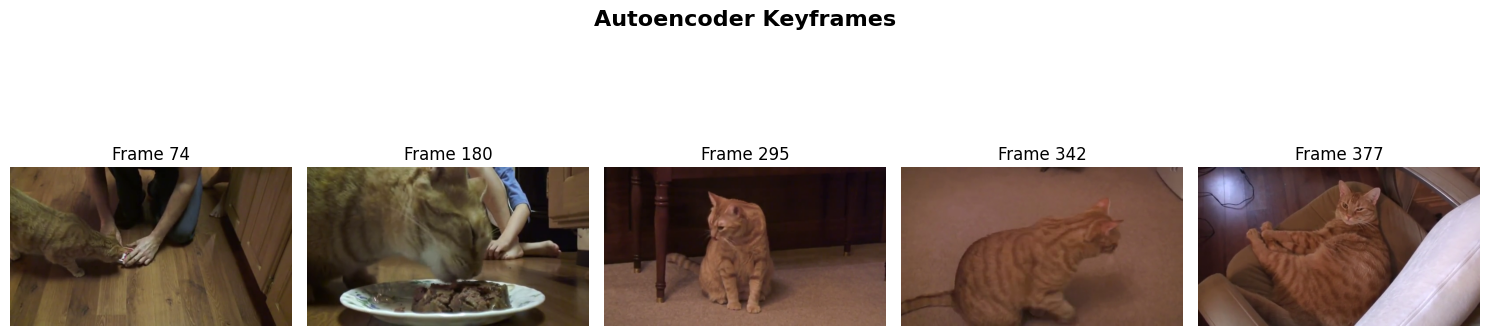

In [ ]:
if __name__ == "__main__":
    if setup_paths():
        encoder = train_unsupervised_tf(VIDEO_DIR)
        test_search = glob.glob(os.path.join(VIDEO_DIR, f"*{TEST_VIDEO_ID}*"))
        if test_search:
            test_path = test_search[0]
            evaluate_keyframes(encoder, test_path, TOP_K)
        else:
            print(f"Test video {TEST_VIDEO_ID} not found.")
